In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


## 1. Tokenizer 준비
8000의 vocab_size를 갖는 sentencepiece 모델

In [6]:
import sentencepiece as spm
import os

corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

data_dir = './data'
model_dir = './models'

model_prefix = model_dir + '/ko_8000'

pretrain_json_path = data_dir + '/bert_pre_train.json'

vocab_size = 8000

In [48]:
print(model_prefix)
print(pretrain_json_path)
mm = f"{model_dir}/ko_8000"
mm

./models/ko_8000
./data/bert_pre_train.json


'./models/ko_8000'

In [2]:

spm.SentencePieceTrainer.train(f"--input={corpus_file} \
                               --model_prefix={model_prefix} \
                               --vocab_size={vocab_size + 7} \
                               --model_type=bpe \
                               --max_sentence_length=999999 \
                               --pad_id=0 --pad_piece=[PAD] \
                               --unk_id=1 --unk_piece=[UNK] \
                               --bos_id=2 --bos_piece=[BOS] \
                               --eos_id=3 --eos_piece=[EOS] \
                               --user_defined_symbols=[SEP],[CLS],[MASK]")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/bert_pretrain/data/kowiki.txt                                --model_prefix=models/ko_8000                                --vocab_size=8007                                --model_type=bpe                                --max_sentence_length=999999                                --pad_id=0 --pad_piece=[PAD]                                --unk_id=1 --unk_piece=[UNK]                                --bos_id=2 --bos_piece=[BOS]                                --eos_id=3 --eos_piece=[EOS]                                --user_defined_symbols=[SEP],[CLS],[MASK]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/bert_pretrain/data/kowiki.txt
  input_format: 
  model_prefix: models/ko_8000
  model_type: BPE
  vocab_size: 8007
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 100000

In [9]:


# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_prefix}.model")

vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

# 확인
print(f"정상 토큰 수: {len(vocab_list)}")
print("예시:", vocab_list[1:10])

정상 토큰 수: 8000
예시: ['▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']


## 2. 데이터 전처리 (1) MASK 생성
BERT의 MLM에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만들어 주세요. 
그 중 80%는 [MASK] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용하세요

In [52]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)
    
    # mask 실행
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
              break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
              continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            
            mask_lms.append({"index": index, "label": tokens[index], "masked": masked_token})
            tokens[index] = masked_token

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    #return tokens, mask_lms, mask_idx, mask_label
    return tokens, mask_idx, mask_label

## 3. 데이터 전처리 (2) NSP pair 생성

In [53]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):  
            del tokens_a[0]                      # A가 더 길면 앞에서 하나 제거
        else:
            tokens_b.pop()                       # B가 더 길거나 같으면 뒤에서 하나 제거

In [54]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    
    for i in range(len(doc)):  # doc 전체를 loop
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
                
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
                
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)


            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label 
            }
            instances.append(instance)
        
            current_chunk = []
            current_length = 0
        
       
    return instances

## 4. 데이터 전처리 (3) 데이터셋 완성
BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 
데이터셋의 사이즈가 크므로np.memmap을 사용해 메모리 사용량을 최소화해 보세요.

In [5]:
# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [13]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    # [[YOUR CODE]]
                    if 0 < len(doc):
                        # save
                        save_pretrain_instances(out_f, doc)
                        doc = []
                        
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    # [[YOUR CODE]]
                    pieces = vocab.encode_as_pieces(line) 
                    if 0 < len(pieces):
                        doc.append(pieces)
                    
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                # [[YOUR CODE]]
                # save
                save_pretrain_instances(out_f, doc)
                doc = []

In [14]:
make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

  0%|          | 0/3957761 [00:00<?, ?it/s]

918189

~/aiffel/quest_rs/GoingDeeper/Gd06/data# head bert_pre_train.json

{"tokens": ["[CLS]", "[MASK]", "[MASK]", "▁카", "터", "[SEP]", "▁제임스", "▁얼", "[MASK]", "[MASK]", "[MASK]", "[MASK]", "▁카", "터", "▁주", "니어", "(,", "▁192", "4", "년", "▁10", "월", "▁1", "일", "[MASK]", "▁)", "는", "▁민주", "당", "▁출신", "▁미국", "▁3", "9", "번째", "▁대통령", "▁(19", "7", "7", "년", "[MASK]", "▁1981", "년", ")", "이다", ".", "[MASK]", "[MASK]", "▁카", "터", "는", "▁조지", "아", "주", "▁섬", "터", "▁카운", "티", "▁플", "레", "인", "스", "▁마을", "에서", "取", "가로", "▁조지", "아", "▁공", "과", "대학교", "를", "▁졸업", "하였다", ".", "▁그", "[MASK]", "▁해", "군에", "▁들어가", "▁전", "함", "·", "원", "자", "력", "·", "잠", "수", "함", "의", "▁승", "무", "원으로", "[MASK]", "[MASK]", "[MASK]", "▁195", "3", "년", "▁미국", "▁해군", "▁대", "위로", "▁예", "편", "하였고", "[MASK]", "▁땅", "콩", "·", "면", "화", "[MASK]", "▁가", "꿔", "▁많은", "▁돈", "을", "▁벌", "었다", ".", "▁그의", "▁별", "명이", "▁\"", "땅", "콩", "[SEP]"], "segment": [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "is_next": 1, "mask_idx": [1, 2, 8, 9, 10, 11, 24, 39, 45, 46, 63, 64, 75, 93, 94, 95, 106, 112], "mask_label": ["▁지", "미", "▁\"", "지", "미", "\"", "▁~", "▁~", "▁지", "미", "▁태어났다", ".", "▁후", "▁일", "하였다", ".", "▁이후", "▁등을"]}

{"tokens": ["[CLS]", "아", "▁주", "▁상", "원", "▁의원", "▁선거", "에서", "▁낙", "선", "하나", "▁그", "斬", "冕", "[MASK]", "[MASK]", "▁", "였", "음을", "▁입", "증", "하게", "▁되어", "▁당선", "되고", ",", "▁196", "6", "년", "▁조지", "아", "▁주", "▁지", "사", "▁선거", "에", "▁낙", "선", "하지만", "▁1970", "년", "[MASK]", "[MASK]", "▁주", "▁지", "사를", "▁역임", "했다", ".", "▁대통령", "이", "▁되", "기", "▁전", "▁조지", "아", "주", "▁상", "원의", "원을", "▁두", "번", "▁연", "임", "했으며", ",", "▁1971", "년부터", "▁1975", "년까지", "▁조지", "아", "[MASK]", "[MASK]", "▁근무", "했다", ".", "▁조지", "아", "▁주", "지", "사로", "▁지", "내", "면서", ",", "[MASK]", "[MASK]", "▁사는", "▁흑", "인", "▁등", "용", "법을", "▁내", "세", "웠다", ".", "[SEP]", "▁1976", "년", "▁대통령", "[MASK]", "[MASK]", "▁민주", "당", "[MASK]", "[MASK]", "▁출", "마", "하여", "▁도", "덕", "주의", "▁정책", "으로", "▁내", "세", "워", ",", "[MASK]", "[MASK]", "[MASK]", "[MASK]", "▁당선", "되었다", ".", "[SEP]"], "segment": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "is_next": 1, "mask_idx": [12, 13, 14, 15, 41, 42, 72, 73, 86, 87, 102, 103, 106, 107, 120, 121, 122, 123], "mask_label": ["▁선거", "가", "▁부정", "선거", "▁조지", "아", "▁지", "사로", "▁미국", "에", "▁선거", "에", "▁후보", "로", "▁포", "드를", "▁누", "르고"]}

### json file 로딩 

In [10]:
data_dir = './data'
model_dir = './models'
model_prefix = model_dir + '/ko_8000'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_prefix}.model")

vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

# 확인
print(f"정상 토큰 수: {len(vocab_list)}")
print("예시:", vocab_list[1:10])

정상 토큰 수: 8000
예시: ['▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']


In [11]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [12]:
# 128000건만 메모리에 로딩
#pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

# 전체
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128)

  0%|          | 0/918189 [00:00<?, ?it/s]

/tmp/ipykernel_64/2049745891.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_64/2049745891.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

In [20]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,    6,    6,  207, 3714,    4, 3324, 1042,    6,    6,    6,
            6,  207, 3714,   37, 3418,  416,  810, 3666, 3625,  131, 3662,
            7, 3629,    6,  241, 3602, 1114, 3724,  788,  243,   49, 3632,
          796,  663, 1647, 3682, 3682, 3625,    6, 3008, 3625, 3616,   16,
         3599,    6,    6,  207, 3714, 3602, 1755, 3630, 3646,  630, 3714,
         3565, 3835,  429, 3740, 3628, 3626, 1369,   10, 5736, 2603, 1755,
         3630,   41, 3644,  830, 3624, 1135,   52, 3599,   13,    6,   87,
         1501, 2247,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,  249, 3725, 1232,    6,    6,    6,  479, 3652, 3625,
          243, 2780,   14, 1509,  168, 3877,  414,    6, 1697, 4290, 3873,
         3703, 3683,    6,   21, 5007,  399, 1927, 3607,  813,   17, 3599,
          307,  587,  931,  103, 4313, 4290,    4], dtype=int32),
 memmap([   5, 3676,  848, 3784, 1931,   58, 3676,  416, 2316, 3619, 3625,
         3617, 3744, 4335,   12, 3

### train set과 validation set 나누기

In [13]:
print(type(pre_train_inputs))
print(np.shape(pre_train_inputs))

<class 'tuple'>
(2, 918189, 128)


In [14]:
# pre_train_inputs : (enc_tokens, segments), 
# pre_train_labels : (labels_nsp, labels_mlm)


from sklearn.model_selection import train_test_split

enc_tokens, segments = pre_train_inputs
labels_nsp, labels_mlm = pre_train_labels

train_tokens, test_tokens, train_segments, test_segments, train_nsp, test_nsp, train_mlm, test_mlm = \
    train_test_split( enc_tokens, segments, labels_nsp, labels_mlm, 
                        test_size=0.2, random_state=42 )

train_inputs = (train_tokens, train_segments)
test_inputs = (test_tokens, test_segments)
train_labels = (train_nsp, train_mlm)
test_labels = (test_nsp, test_mlm)

print('훈련 데이타 셋 : ', len(train_tokens))
print('테스트 데이타 셋 : ', len(test_tokens))

훈련 데이타 셋 :  734551
테스트 데이타 셋 :  183638


## 5. BERT 모델 구현

In [15]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [16]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

In [17]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

In [18]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

### Shared Embedding

1. 파라미터 수 감소 (Parameter Efficiency)
     BERT는 **입력 임베딩 (Embedding Layer)**과 **출력 소프트맥스 레이어 (Output Layer)**에서 동일한 vocabulary embedding weight를 사용합니다.

    * 입력: 토큰 → 벡터
    * 출력: 벡터 → 토큰 (softmax)

    둘 다 vocabulary size × hidden size (vocab_size × d_model)의 weight matrix를 사용하므로, 
    별도로 두 개를 만들면 매우 많은 파라미터가 필요합니다.
    → 하나로 공유하면 파라미터 수가 절반으로 줄어듭니다.
    

2. 학습 안정성과 일반화 성능 향상
    * 모델이 입력 표현과 출력 표현을 동일한 공간에서 해석하게 되어 일관성이 생기고,

    * 특히 language modeling처럼 출력이 입력의 연장선인 문제에서는 더 효과적입니다.

    즉, 단어의 의미를 임베딩과 디코딩에서 공유함으로써, 일반화 성능이 좋아지고 과적합 가능성이 줄어듭니다.

In [19]:
# 임베딩 레이어와 출력 softmax 레이어에서 공유되는 가중치 
# - 입력 임베딩 시에는 input_ids → shared_weights lookup
# - 출력 예측 시에는 decoder output → shared_weights^T → softmax
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):                      # tf.keras.layers.Layer 클래스가 처음 call()될 때 자동 호출
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(     # 이 레이어에 학습 가능한 가중치를 추가하는 Keras 메서드
                "weights",                             # self.add_weight로 생성된 가중치는 model.trainable_variables에 자동으로 포함
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        # inputs : [batch_size, seq_len]
        # self.shared_weights : shape: [vocab_size, d_model]인 임베딩 가중치 행렬 
        # tf.gather(..., indices) : indices에 해당하는 행(벡터)만 뽑아오는 함수
        # 즉, 전체 vocab 임베딩에서, inputs에 토큰에 대해서만 뽑아옴(lookup)
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed 
        # shape: [batch_size, seq_len, d_model]
        # 각 토큰을 d_model 차원의 벡터로 임베딩

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        
        # self.shared_weights : [vocab_size, d_model]인 임베딩 가중치 행렬과 matmul하려고
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        
        # decoder output * shared_weights^T 
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        
        # softmax를 하려고 n_vocab로 변경
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

**학습 가능한 위치 임베딩 (learnable position embedding)**

In [20]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        # tf.ones_like(inputs) : inputs와 같은 shape의 텐서를 만들되, 모든 값을 1로 채운다. 
        # tf.math.cumsum(..., axis=1, exclusive=True) : 누적합을 구하되, 자기자신은 포함하지 않음 (즉, 앞의 값들만 합함)
        # --> 각 토큰의 위치 인덱시 [0,1,2,3,4,...]
        embed = self.embedding(position)
        return embed
        # [batch_size, seq_len, d_model]

### Encoder Layer

In [21]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_mode)

        return attn_out

**포지션-와이즈 피드포워드 네트워크(Position-wise Feed-Forward Network, FFN)**

    각 시퀀스의 토큰 벡터에 독립적으로 적용

    FFN(x)=W2( activation(W1(x) )
    - W_1 : 입력을 넓힘 d_model-> d_ff
    - W_2 : 다시 원래 차원으로 줄일

In [23]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

### BERT

    * Embedding=TokenEmbedding+PositionEmbedding+SegmentEmbedding

In [25]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]   # 각 문장의 첫 번째 위치 토큰(보통 [CLS])에 해당하는 벡터만 선택
                                    # NSP (Next Sentence Prediction) 작업을 위한 입력으로 사용
        logits_lm = self.embedding(enc_out, mode="linear")  # MLM을 위한 로짓 
        return logits_cls, logits_lm
        # logits_cls: [CLS] 토큰의 최종 벡터 (shape: [batch_size, hidden_dim]) (hidden_dim = d_model)
        # logits_lm: MLM을 위한 로짓 (shape: [batch_size, seq_len, vocab_size])

    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        # 서로 다른 분포를 가진 임베딩 벡터들을 더하면, 각 차원별 값의 스케일이 불균형해질 수 있고
        # 학습이 불안정해질 가능성이 생기므로, 
        # LayerNormalization으로 스케일 차이를 조정 (출력의 평균을 0, 분산을 1에 가깝게 맞춤)
        embed = self.norm(embed)
        return embed

In [26]:
# [CLS] 토큰에서 나온 문장 전체의 표현을 사용해
# NSP (Next Sentence Prediction) 또는 다른 이진/다중 분류 작업을 처리하기 위한 작은 분류기(classifier)
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [27]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

## 6. pretrain 진행
loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 10 Epoch까지 모델 학습을 시켜보세요.
학습을 진행할 때는 배치 사이즈에 유의하세요.

In [28]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

In [29]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [30]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

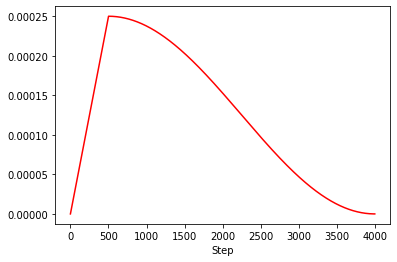

In [31]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

## 모델 학습

In [35]:
config_4m = Config({"d_model": 256, 
                 "n_head": 4, 
                 "d_head": 64, 
                 "dropout": 0.1, 
                 "d_ff": 1024, 
                 "layernorm_epsilon": 0.001, 
                 "n_layer": 3, 
                 "n_seq": 256, 
                 "n_vocab": 0, 
                 "i_pad": 0})
config_4m.n_vocab = len(vocab)
config_4m.i_pad = vocab.pad_id()
print('Config : ', config_4m)
# 모델 생성
model_4 = build_model_pre_train(config=config_4m)
model_4.summary()

Config :  {'d_model': 256, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'd_ff': 1024, 'layernorm_epsilon': 0.001, 'n_layer': 3, 'n_seq': 256, 'n_vocab': 8007, 'i_pad': 0}
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4387328     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
______________________

In [49]:
config = Config({"d_model": 128, 
                 "n_head": 2, 
                 "d_head": 64, 
                 "dropout": 0.1, 
                 "d_ff": 512, 
                 "layernorm_epsilon": 0.001, 
                 "n_layer": 2, 
                 "n_seq": 128, 
                 "n_vocab": 0, 
                 "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
print('Config : ', config)

# 모델 생성
model_1 = build_model_pre_train(config)
model_1.summary()


Config :  {'d_model': 128, 'n_head': 2, 'd_head': 64, 'dropout': 0.1, 'd_ff': 512, 'layernorm_epsilon': 0.001, 'n_layer': 2, 'n_seq': 128, 'n_vocab': 8007, 'i_pad': 0}
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 128), (None, 1438336     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
_______________________

In [36]:
config = Config({"d_model": 128, 
                 "n_head": 2, 
                 "d_head": 64, 
                 "dropout": 0.1, 
                 "d_ff": 512, 
                 "layernorm_epsilon": 0.001, 
                 "n_layer": 2, 
                 "n_seq": 128, 
                 "n_vocab": 0, 
                 "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
print('Config : ', config)

# 모델 생성
model_1 = build_model_pre_train(config)
model_1.summary()

#
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


# compile
# nsp loss : sparse_categorical_crossentropy
# mlm loss : lm_loss (예: MLM을 위한 사용자 정의 함수)
#pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), \
#                       optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})
model_1.compile(
                loss={"nsp": tf.keras.losses.sparse_categorical_crossentropy, 
                      "mlm": lm_loss},
                optimizer=optimizer,
                metrics={"nsp": "accuracy", 
                         "mlm": lm_acc}
                )

# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train_1.hdf5",\
                monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", \
                ave_freq="epoch", save_weights_only=True)
# train
history_1 = model_1.fit(train_inputs, train_labels,
                              epochs=epochs, 
                              batch_size=batch_size, 
                              callbacks=save_weights,
                              validation_data=(test_inputs, test_labels)
                       )


Config :  {'d_model': 128, 'n_head': 2, 'd_head': 64, 'dropout': 0.1, 'd_ff': 512, 'layernorm_epsilon': 0.001, 'n_layer': 2, 'n_seq': 128, 'n_vocab': 8007, 'i_pad': 0}
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 128), (None, 1438336     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
_______________________

In [55]:
print(history_1.history.keys())

dict_keys(['loss', 'nsp_loss', 'mlm_loss', 'nsp_accuracy', 'mlm_lm_acc', 'val_loss', 'val_nsp_loss', 'val_mlm_loss', 'val_nsp_accuracy', 'val_mlm_lm_acc'])


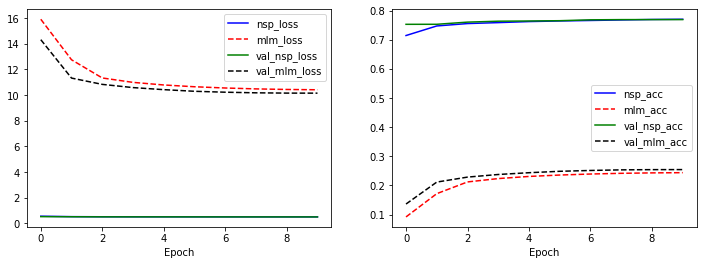

In [38]:
# training result
plt.figure(figsize=(12, 4))

history = history_1

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.plot(history.history['val_nsp_loss'], 'g-', label='val_nsp_loss')
plt.plot(history.history['val_mlm_loss'], 'k--', label='val_mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_accuracy'], 'b-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'r--', label='mlm_acc')
plt.plot(history.history['val_nsp_accuracy'], 'g-', label='val_nsp_acc')
plt.plot(history.history['val_mlm_lm_acc'], 'k--', label='val_mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 결과물 저장

In [41]:
# 저장
save_model_path = model_dir + "/mini_bert_model"
save_weights_path = model_dir + "/mini_bert_weights.h5"

model_1.save(save_model_path, include_optimizer=False)
model_1.save_weights(save_weights_path)

INFO:tensorflow:Assets written to: ./models/mini_bert_model/assets


INFO:tensorflow:Assets written to: ./models/mini_bert_model/assets


In [46]:
# tokenizer_config.json	토크나이저 구성 저장용
import json

tokenizer_config = {
    "model_file": "ko_8000.model",     # SentencePiece 모델 파일 경로
    "vocab_file": "ko_8000.vocab",
    "vocab_size": 8000 + 7,                 # 학습 시 설정한 vocab 크기, 7개 특수 토큰 포함
    "pad_id": 0,
    "pad_piece": "[PAD]",
    "unk_id": 1,
    "unk_piece": "[UNK]",
    "bos_id": 2,
    "bos_piece": "[BOS]",
    "eos_id": 3,
    "eos_piece": "[EOS]",
    "user_defined_symbols": ["[SEP]", "[CLS]", "[MASK]"],
    "model_type": "bpe",
    "add_bos": True,                         # encode 시 BOS 붙이는 경우
    "add_eos": True,                         # encode 시 EOS 추가 여부
    "normalization_rule_name": "nmt_nfkc",   # 기본 SentencePiece normalization (필요 시 조정)
    "split_by_whitespace": True              # 공백 기준 분할 여부 (기본 True)
}
tokenizer_config_path = model_dir + "/tokenizer_config.json"

# 저장
with open(tokenizer_config_path, "w", encoding="utf-8") as f:
    json.dump(tokenizer_config, f, indent=4, ensure_ascii=False)

    
print("tokenizer_config.json:" )
# 파일 읽기
with open(tokenizer_config_path, "r") as f:
    tok_config = json.load(f)

# 출력
print(json.dumps(tok_config, indent=4, ensure_ascii=False))  # 한글 깨짐 방지

tokenizer_config.json:
{
    "model_file": "ko_8000.model",
    "vocab_file": "ko_8000.vocab",
    "vocab_size": 8007,
    "pad_id": 0,
    "pad_piece": "[PAD]",
    "unk_id": 1,
    "unk_piece": "[UNK]",
    "bos_id": 2,
    "bos_piece": "[BOS]",
    "eos_id": 3,
    "eos_piece": "[EOS]",
    "user_defined_symbols": [
        "[SEP]",
        "[CLS]",
        "[MASK]"
    ],
    "model_type": "bpe",
    "add_bos": true,
    "add_eos": true,
    "normalization_rule_name": "nmt_nfkc",
    "split_by_whitespace": true
}


In [50]:
# pretrain_config.json
# - 모델 구성 (hidden size, layers 등) 저장용
import json

# 파일 경로 지정
config_path = model_dir + "/pretrain_config.json"

# 저장
with open(config_path, "w") as f:
    json.dump(config, f, indent=4)

print("pretrain_config.json:" )
# 파일 읽기
with open(config_path, "r") as f:
    model_config = json.load(f)

# 출력
print(json.dumps(model_config, indent=4, ensure_ascii=False))  # 한글 깨짐 방지

pretrain_config.json:
{
    "d_model": 128,
    "n_head": 2,
    "d_head": 64,
    "dropout": 0.1,
    "d_ff": 512,
    "layernorm_epsilon": 0.001,
    "n_layer": 2,
    "n_seq": 128,
    "n_vocab": 8007,
    "i_pad": 0
}


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


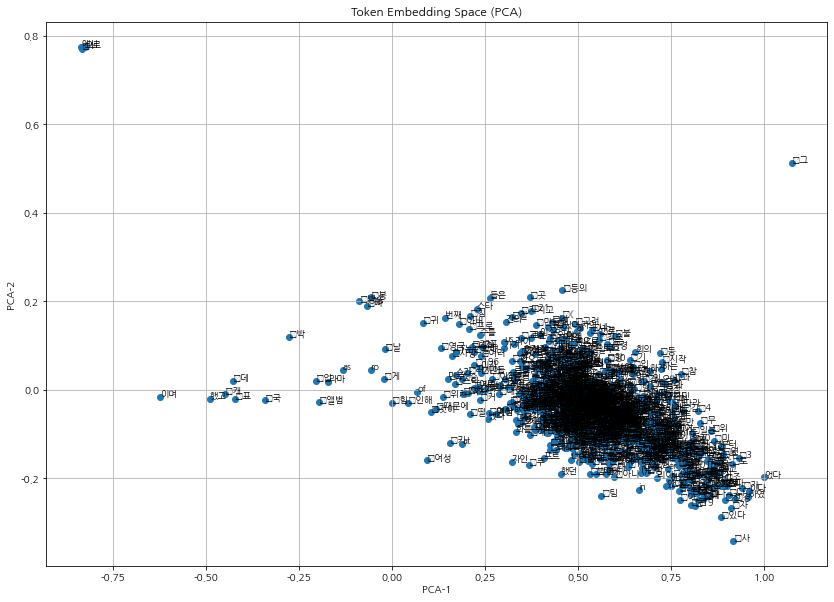

In [72]:
#임베딩 벡터 시각화 (PCA)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import sentencepiece as spm
import matplotlib.font_manager as fm

# 3. 임베딩 벡터 로딩 (예: shared embedding layer의 가중치)
embedding_matrix = model_1.get_layer("bert").embedding.shared_weights.numpy()

# 4. PCA 적용
pca = PCA(n_components=2)
reduced = pca.fit_transform(embedding_matrix)


# 5. 시각화 (상위 N개 단어만)
n = 1000
plt.figure(figsize=(14, 10))
plt.scatter(reduced[:n, 0], reduced[:n, 1], marker='o')

for i in range(n):
    plt.text(reduced[i, 0], reduced[i, 1], vocab_list[i], fontsize=9)

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

plt.title("Token Embedding Space (PCA)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)

## 7. Inference

In [43]:
import tensorflow as tf
import sentencepiece as spm
import numpy as np

# 경로 설정
model_dir = './models'
model_path = f"{model_dir}/mini_bert_model"
model_weights_path = f"{model_dir}/mini_bert_weights.h5"
model_config = f"{model_dir}/pretrain_config.json"
sp_model_path = f"{model_dir}/ko_8000.model"  # SentencePiece 모델 경로

# SentencePiece 로드
sp = spm.SentencePieceProcessor()
sp.load(sp_model_path)

vocab_list = []
for id in range(7, len(sp)):
        if not sp.is_unknown(id):
            vocab_list.append(sp.id_to_piece(id))

# 확인
mask_token_id = sp.piece_to_id("[MASK]")
print("mask_token_id:", mask_token_id)
print(f"정상 토큰 수: {len(vocab_list)}")
print("예시:", vocab_list[1:10])




# 모델 로드 (구조 + 가중치 포함)
model = tf.keras.models.load_model(save_model_path, compile=False)
model.summary()



mask_token_id: 6
정상 토큰 수: 8000
예시: ['▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 128), (None, 1438336     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            16768       bert[0][0]                 

** 문장 복원 **

In [88]:
# 문장을 토크나이징 및 인덱스 변환 함수
def tokenize_sentence(sentences, spm, vocab_list, n_seq=128, mask_prob=0.15 ):

    doc = []
    for line in sentences:
        line = line.strip()
        print(line)
        pieces = spm.encode_as_pieces(line) 
        if 0 < len(pieces):
            doc.append(pieces)
        
    print("doc :", doc)
    instances = create_pretrain_instances(spm, doc, n_seq, mask_prob, vocab_list)
    
    print(f"생성된 인스턴스 수: {len(instances)}")
    
    #label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
    #label_mlm[ instances[0]["mask_idx"] ] = instances[0]["mask_label"]
    
    """
       instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
        }
            
    return (enc_tokens, segments), (labels_nsp, labels_mlm)
    """
    if not instances:
        raise ValueError("입력 문장에서 pretrain instance를 생성할 수 없습니다. 문장 수를 늘리거나 문장 길이를 확인하세요.")
    
    #return (instances[0]["tokens"],instances[0]["segment"]), (instances[0]["is_next"], mask_label)
    return (instances[0]["tokens"],instances[0]["segment"])
             
    

# 입력 문장
texts = [
    "나는 학교에 갔다.",
    "친구와 놀았다.",
    "오늘은 날씨가 좋다.",
    "점심으로 김밥을 먹었다."
]

# 토크나이징 및 입력 데이터 구성
masked_tokens, segments = tokenize_sentence(texts, sp, vocab_list)

# 트큰화 결과 출력
print("토큰 출력:", masked_tokens)
print("Segment 출력:", segments)


token_ids = [sp.piece_to_id(token) for token in masked_tokens]
enc_tokens = np.array([token_ids], dtype=np.int32)  # batch 처리
segments = np.array([segments], dtype=np.int32)


# 추론
outputs_nsp, outputs_mlm = model([enc_tokens, segments], training=False)

# MASK 토큰 복원
mask_positions = np.where(enc_tokens[0] == mask_token_id)[0]  # 배열(마스크 위치들)
print("MASK 위치", mask_positions)

predicted_tokens = masked_tokens.copy()

for pos in mask_positions:
    predicted_token_id = int(tf.argmax(outputs_mlm[0, pos]).numpy())
    pred_token = sp.id_to_piece(predicted_token_id)
    predicted_tokens[pos] = pred_token
    print(f"Masked token at position {pos} predicted as: {pred_token}")

    
# 문장으로 붙이기 
# [CLS], [SEP] 토큰 제거
filtered_tokens = [t for t in predicted_tokens if t not in ("[CLS]", "[SEP]")]
sentence = "".join(filtered_tokens).replace("▁", " ").strip()

print("원문 토큰들:", masked_tokens)
print("예측 토큰들:", predicted_tokens)
print("원래   문장:", " ".join(texts))
print("복원된 문장:", sentence)

나는 학교에 갔다.
친구와 놀았다.
오늘은 날씨가 좋다.
점심으로 김밥을 먹었다.
doc : [['▁나', '는', '▁학교', '에', '▁', '갔다', '.'], ['▁친구', '와', '▁놀', '았다', '.'], ['▁오늘', '은', '▁날', '씨', '가', '▁좋', '다', '.'], ['▁점', '심', '으로', '▁김', '밥', '을', '▁먹', '었다', '.']]
생성된 인스턴스 수: 1
토큰 출력: ['[CLS]', '▁오늘', '은', '▁날', '씨', '가', '▁좋', '다', '.', '▁점', '심', '으로', '▁김', '밥', '을', '▁먹', '었다', '.', '[SEP]', '▁나', '는', '▁학교', '에', '[MASK]', '[MASK]', '[MASK]', '▁친구', '와', '▁놀', '았다', '.', '[SEP]']
Segment 출력: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
MASK 위치 [23 24 25]
Masked token at position 23 predicted as: ▁
Masked token at position 24 predicted as: 녀
Masked token at position 25 predicted as: 의
원문 토큰들: ['[CLS]', '▁오늘', '은', '▁날', '씨', '가', '▁좋', '다', '.', '▁점', '심', '으로', '▁김', '밥', '을', '▁먹', '었다', '.', '[SEP]', '▁나', '는', '▁학교', '에', '[MASK]', '[MASK]', '[MASK]', '▁친구', '와', '▁놀', '았다', '.', '[SEP]']
예측 토큰들: ['[CLS]', '▁오늘', '은', '▁날', '씨', '가', '▁좋', '다', '.', '▁점', '심', '으로', '

--> 추론은 문장을 섞어서 사용하지 않으므로, 잘못된 추론이다 



In [101]:
print(type(outputs_nsp))
print(outputs_nsp)

is_next = tf.argmax(outputs_nsp, axis=-1).numpy()[0]

print("NSP 예측 :",  is_next)

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[0.58647454 0.41352546]], shape=(1, 2), dtype=float32)
NSP 예측 : 0


In [68]:
print( type(masked_tokens))
print( type(enc_tokens))

<class 'list'>
<class 'numpy.ndarray'>


#### MLM 예측

In [111]:
def mlm_inference( masked_text, model, sp, n_seq = 128) : 
    # 1. 토큰화
    tokens = ['[CLS]'] + sp.encode(masked_text, out_type=str) + ['[SEP]']

    # 2. segment 설정 (문장 1만 있으므로 전부 0)
    segments = [0] * len(tokens)

    # 3. 토큰 → ID
    input_ids = [sp.piece_to_id(tok) for tok in tokens]
    mask_token_id = sp.piece_to_id("[MASK]")

    # 4. 길이 맞추기 (padding)
    max_len = n_seq
    input_ids += [0] * (max_len - len(input_ids))
    segments += [0] * (max_len - len(segments))

    # 5. 텐서 변환
    input_ids = tf.constant([input_ids], dtype=tf.int32)
    segments = tf.constant([segments], dtype=tf.int32)

    # 6. 추론
    _, outputs_mlm = model([input_ids, segments], training=False)


    # MASK 토큰 복원
    mask_positions = np.where(input_ids[0] == mask_token_id)[0]  # 배열(마스크 위치들)
    print("MASK 위치", mask_positions)

    predicted_tokens = tokens.copy()

    for pos in mask_positions:
        predicted_token_id = int(tf.argmax(outputs_mlm[0, pos]).numpy())
        pred_token = sp.id_to_piece(predicted_token_id)
        predicted_tokens[pos] = pred_token
        print(f"Masked token at position {pos} predicted as: {pred_token}")

    
    # 문장으로 붙이기 
    # [CLS], [SEP] 토큰 제거
    filtered_tokens = [t for t in predicted_tokens if t not in ("[CLS]", "[SEP]")]
    restored_sentence = "".join(filtered_tokens).replace("▁", " ").strip()


    print(" 마스킹된 문장:", masked_text)
    print(" 예측된 토큰:", predicted_tokens)
    print(" 복원된 문장:", restored_sentence)

In [112]:
# 입력 문장
masked_text = "점심으로 학교에서 [MASK] [MASK] 먹었다."

mlm_inference( masked_text, model, sp)

MASK 위치 [7 9]
Masked token at position 7 predicted as: ▁사람이
Masked token at position 9 predicted as: ▁등을
 마스킹된 문장: 점심으로 학교에서 [MASK] [MASK] 먹었다.
 예측된 토큰: ['[CLS]', '▁점', '심', '으로', '▁학교', '에서', '▁', '▁사람이', '▁', '▁등을', '▁먹', '었다', '.', '[SEP]']
 복원된 문장: 점심으로 학교에서  사람이  등을 먹었다.


In [113]:
# 입력 문장
masked_text = "점심으로 [MASK] 맛있는 [MASK] 먹었다."

mlm_inference( masked_text, model, sp)

MASK 위치 [ 5 10]
Masked token at position 5 predicted as: ▁만든
Masked token at position 10 predicted as: ▁등을
 마스킹된 문장: 점심으로 [MASK] 맛있는 [MASK] 먹었다.
 예측된 토큰: ['[CLS]', '▁점', '심', '으로', '▁', '▁만든', '▁', '맛', '있는', '▁', '▁등을', '▁먹', '었다', '.', '[SEP]']
 복원된 문장: 점심으로  만든 맛있는  등을 먹었다.


In [114]:
# 입력 문장
masked_text = "점심으로 [MASK] [MASK] 김밥을 먹었다."

mlm_inference( masked_text, model, sp)

MASK 위치 [5 7]
Masked token at position 5 predicted as: ▁만든
Masked token at position 7 predicted as: ▁등은
 마스킹된 문장: 점심으로 [MASK] [MASK] 김밥을 먹었다.
 예측된 토큰: ['[CLS]', '▁점', '심', '으로', '▁', '▁만든', '▁', '▁등은', '▁김', '밥', '을', '▁먹', '었다', '.', '[SEP]']
 복원된 문장: 점심으로  만든  등은 김밥을 먹었다.


In [115]:
# 입력 문장
masked_text = "점심으로 [MASK] 떡복이와 [MASK] 김밥을 먹었다."

mlm_inference( masked_text, model, sp)

MASK 위치 [ 5 12]
Masked token at position 5 predicted as: ▁또는
Masked token at position 12 predicted as: ▁또는
 마스킹된 문장: 점심으로 [MASK] 떡복이와 [MASK] 김밥을 먹었다.
 예측된 토큰: ['[CLS]', '▁점', '심', '으로', '▁', '▁또는', '▁', '떡', '복', '이', '와', '▁', '▁또는', '▁김', '밥', '을', '▁먹', '었다', '.', '[SEP]']
 복원된 문장: 점심으로  또는 떡복이와  또는 김밥을 먹었다.


In [117]:
# 입력 문장
masked_text = "점심으로 매운 [MASK] 과 [MASK] 김밥을 먹었다."

mlm_inference( masked_text, model, sp)

MASK 위치 [ 7 10]
Masked token at position 7 predicted as: ▁같은
Masked token at position 10 predicted as: ▁또는
 마스킹된 문장: 점심으로 매운 [MASK] 과 [MASK] 김밥을 먹었다.
 예측된 토큰: ['[CLS]', '▁점', '심', '으로', '▁매', '운', '▁', '▁같은', '▁과', '▁', '▁또는', '▁김', '밥', '을', '▁먹', '었다', '.', '[SEP]']
 복원된 문장: 점심으로 매운  같은 과  또는 김밥을 먹었다.


In [122]:
# 입력 문장
masked_text = "점심으로 매운 떡볶이를 먹고 배가 아파서 [MASK] [MASK] 갔다"

mlm_inference( masked_text, model, sp)

MASK 위치 [18 20]
Masked token at position 18 predicted as: ▁
Masked token at position 20 predicted as: ▁등으로
 마스킹된 문장: 점심으로 매운 떡볶이를 먹고 배가 아파서 [MASK] [MASK] 갔다
 예측된 토큰: ['[CLS]', '▁점', '심', '으로', '▁매', '운', '▁', '떡', '볶', '이를', '▁먹', '고', '▁배', '가', '▁아', '파', '서', '▁', '▁', '▁', '▁등으로', '▁', '갔다', '[SEP]']
 복원된 문장: 점심으로 매운 떡볶이를 먹고 배가 아파서    등으로 갔다


#### NSP 예측

In [124]:
def nsp_inference( sentence_a, sentence_b, model, sp, n_seq = 128) : 
    sentence_a_tokens = sp.encode_as_pieces(sentence_a) 
    sentence_b_tokens = sp.encode_as_pieces(sentence_b)

    # 2. special tokens 추가: [CLS], [SEP], [SEP]
    token_org = ["[CLS]"] + sentence_a_tokens + ["[SEP]"] + sentence_b_tokens + ["[SEP]"]
    segments = [0] * (len(sentence_a_tokens)+2) + [1] * (len(sentence_b_tokens)+1)
    print("TOKEN :", token_org)
    print("SEGM :", segments)

    # 3. 토큰을 ID로 변환
    input_ids = [sp.piece_to_id(p) for p in tokens]

    # 4. 길이 맞추기 (padding)
    max_len = n_seq
    input_ids += [0] * (max_len - len(input_ids))
    segments += [0] * (max_len - len(segments))

    # 5. numpy → tensor
    input_ids = tf.constant([input_ids], dtype=tf.int32)
    segments = tf.constant([segments], dtype=tf.int32)

    # 6. 모델 추론
    outputs_nsp, _ = model([input_ids, segments], training=False)

    # 7. 결과 해석
    probs = tf.nn.softmax(outputs_nsp, axis=-1).numpy()[0]
    label = np.argmax(probs)

    print(f"NSP 예측 결과: {'✔️ 이어지는 문장' if label == 0 else '❌ 무작위 문장'}")
    print(f" - 연속 확률: {probs[0]:.4f}")
    print(f" - 무작위 확률: {probs[1]:.4f}")

In [126]:
# 입력 문장
sentence_a = "나는 학교에 갔다. 친구와 놀았다."
sentence_b = "오늘은 날씨가 좋다. 점심으로 김밥을 먹었다."

nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '▁나', '는', '▁학교', '에', '▁', '갔다', '.', '▁친구', '와', '▁놀', '았다', '.', '[SEP]', '▁오늘', '은', '▁날', '씨', '가', '▁좋', '다', '.', '▁점', '심', '으로', '▁김', '밥', '을', '▁먹', '었다', '.', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
NSP 예측 결과: ✔️ 이어지는 문장
 - 연속 확률: 0.5519
 - 무작위 확률: 0.4481


In [128]:
# 입력 문장
sentence_a = "오늘은 날씨가 좋다. 점심으로 김밥을 먹었다."
sentence_b = "나는 학교에 갔다. 친구와 놀았다."

nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '▁오늘', '은', '▁날', '씨', '가', '▁좋', '다', '.', '▁점', '심', '으로', '▁김', '밥', '을', '▁먹', '었다', '.', '[SEP]', '▁나', '는', '▁학교', '에', '▁', '갔다', '.', '▁친구', '와', '▁놀', '았다', '.', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
NSP 예측 결과: ✔️ 이어지는 문장
 - 연속 확률: 0.5519
 - 무작위 확률: 0.4481


In [138]:
sentence_a = "초록색 철한 대문 하나가 분위기에 큰 영향을 준다"
sentence_b = "오늘 점심 메뉴는 불고기 이다."
nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '▁초', '록', '색', '▁철', '한', '▁대', '문', '▁하나', '가', '▁분', '위', '기에', '▁큰', '▁영향을', '▁준', '다', '[SEP]', '▁오늘', '▁점', '심', '▁메', '뉴', '는', '▁불', '고', '기', '▁이', '다', '.', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
NSP 예측 결과: ✔️ 이어지는 문장
 - 연속 확률: 0.5519
 - 무작위 확률: 0.4481


In [137]:
# 입력 문장
#sentence_a = "멋진 분수대 꼭 놔야겠다."
#sentence_a = "나는 따라갈려먼 아직 멀었다."
sentence_a = "더 노력하고 더 세심해야겠다"
sentence_b = "초록색 철한 대문 하나가 분위기에 큰 영향을 준다"

nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '▁더', '▁노력', '하고', '▁더', '▁세', '심', '해야', '겠', '다', '[SEP]', '▁초', '록', '색', '▁철', '한', '▁대', '문', '▁하나', '가', '▁분', '위', '기에', '▁큰', '▁영향을', '▁준', '다', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
NSP 예측 결과: ❌ 무작위 문장
 - 연속 확률: 0.3988
 - 무작위 확률: 0.6012


In [139]:
sentence_a = "오늘은 날씨가 좋다."
sentence_b = "나는 컴퓨터를 좋아한다."
nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '▁오늘', '은', '▁날', '씨', '가', '▁좋', '다', '.', '[SEP]', '▁나', '는', '▁컴퓨터', '를', '▁좋아', '한다', '.', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
NSP 예측 결과: ❌ 무작위 문장
 - 연속 확률: 0.3949
 - 무작위 확률: 0.6051


In [145]:
sentence_a = "오늘은 날씨가 좋다."
sentence_b = "운동장에 축구하러 갈거다."
nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '▁오늘', '은', '▁날', '씨', '가', '▁좋', '다', '.', '[SEP]', '▁운동', '장에', '▁축구', '하', '러', '▁갈', '거', '다', '.', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
NSP 예측 결과: ❌ 무작위 문장
 - 연속 확률: 0.3949
 - 무작위 확률: 0.6051


# <회고>

### 루브릭

1. 한글 코퍼스를 가공하여 BERT pretrain용 데이터셋을 잘 생성하였다.	
- MLM, NSP task의 특징이 잘 반영된 pretrain용 데이터셋 생성과정이 체계적으로 진행되었다.
2. 구현한 BERT 모델의 학습이 안정적으로 진행됨을 확인하였다.	
- 학습진행 과정 중에 MLM, NSP loss의 안정적인 감소가 확인되었다.
3. 1M짜리 mini BERT 모델의 제작과 학습이 정상적으로 진행되었다.	
- 학습된 모델 및 학습과정의 시각화 내역이 제출되었다.

📄 Mini BERT Pretraining 결과 리포트 

1. 모델 구성 (Model Config)
| 항목              | 값      |
|-------------------|---------|
| d_model           | 128     |
| n_head            | 2       |
| d_head            | 64      |
| dropout           | 0.1     |
| d_ff              | 512     |
| layernorm_epsilon | 0.001   |
| n_layer           | 2       |
| n_seq             | 128     |
| n_vocab           | 8007    |
| i_pad             | 0       |
| Total Parameters      | 1.4M      |

2. Pretraining 설정
| 항목                  | 값                                |
|-----------------------|-----------------------------------|
| Dataset               | 나무 위치 말뭉치  |
| Tokenizer             | SentencePiece                     |
| Pretrain Task         | MLM + NSP                         |
| Epochs                | 10                                |
| Batch Size            | 64                                |
| Learning Rate Scheduler | Warmup (4000 step)              |
| Max Sequence Length   | 128                               |

3. 학습 결과 요약

| 메트릭         | Final Train | Final Val |
|----------------|-------------|-----------|
| MLM Loss       | 10.4110      | 10.1469     |
| MLM Accuracy   | 0.2437      | 0.2543     |
| NSP Loss       | 0.5036      | 0.5015    |
| NSP Accuracy   | 0.7707     | 0.7695    |



### Inference 결과 및 회고

1. 문장 순서 변환 : 50% 비율로 랜덤하게 섞어서, 문장 순서가 바뀌었다 추론에서 잘못 사용한 예이다. 

    texts = [
        "나는 학교에 갔다.",
        "친구와 놀았다.",
        "오늘은 날씨가 좋다.",
        "점심으로 김밥을 먹었다."
    ]     --> 점심으로 김밥을 먹었다. 나는 학교에 갔다. 친구와 놀았다. 이은 날씨가 좋다.
    

2. MLM 예측 
   -  [MASK] 위치를 변화시키면서 확인해 봤을 때, 동일한 토큰들이 계속해서 예측되는 현상이 있다. 
   - mini 모델이라 MLM loss/accuracy 성능이 안 좋으므로, MASK에 대한 예측이 좋지 않다. 
   
3. NSP 예측 
    - 연속문장 확률과 무작위 문장 확률의 차이가 크지 않다.
    - 기본적으로 50%인데, 77% 정확도록 예측을 하고 있는데, 실제 추론 실험에서는 잘 안 맞는 듯 하다. 

4. Pretrained model은 직접쓸 모델이 아니라, 감성분류, QA같은 downstream task에 맞게 fine-tuning해서 사용하는 것